## Instrumental Variables in Canonical Demand & Supply Model



### Data-Generating Process



In [5]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Unobservable component of supply shock z
# Can have any distribution one pleases
# w is the shock that affects v --> mean 0 here
w = iid.beta(1,2,loc=-iid.beta(1,2).mean()) # Centered for convenience

# Structural parameters; of interest! assuming off diagonals in covariance matrix are zero
(alpha,beta) = (-1,2)     
sigma = {'u':1/2,'v':1/3}
mu = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=mu['u'], scale=sigma['u'])  # Demand shocks
v = iid.norm(loc=mu['v'], scale=sigma['v'])  # Supply shocks

# Reduced form coefficients
pi = [[-beta/(alpha - beta), -1/(alpha - beta)],
     [ alpha/(alpha - beta), 1/(alpha - beta)]]

# Generate N realizations of system
# Outcomes have columns (p,q,z)
def wright_dgp(N):
    """
    Generate data consistent with Wright (1934) hog demand and supply.

    Returns a pandas dataframe with N observations on (p,q,z), where
    z is understood to be a supply shock.
    """
    
    # Arrange shocks into an Nx2 matrix
    U = np.c_[u.rvs(N), v.rvs(N)]    # these are N normal draws 

    # Matrix product gives [q,p]; label by putting into df
    df = pd.DataFrame(U@pi,columns=['q','p'])

    Udf = pd.DataFrame(U,columns=['u','v']) # For future reference

    # Relate v and z (need not be linear)
    unobserved_shock = w.rvs(N)/10
    df['z'] = (1-unobserved_shock)*np.exp(4*Udf['v'] - unobserved_shock) 
    # set z equals w/10 * some crazy fn of v
    df['Constant'] = 1

    # Include a constant term in both X & Z
    return df[['q']],df[['Constant','p']],df[['Constant','z']]

### Estimation



Let&rsquo;s write some code to estimate the parameters of the regression
   model using the estimator devised above (the &ldquo;simple IV estimator&rdquo;):



In [6]:
import numpy as np

def draw_b(N,dgp):
    """
    Generate a random variate $b$ from a sample of $N$ draws from a function dgp.
    """
    y,X,Z =  dgp(N)

    return np.linalg.solve(Z.T@X,Z.T@y) # Solve normal eqs for b

b = draw_b(10000,wright_dgp)

print(b)

[[ 1.95617557]
 [-0.9569832 ]]


### Inference



Now consider the point that the estimator $b$ is a random variable.
 Under the assumptions of the *model* a Central Limit Theorem applies,
 so it&rsquo;s asymptotically normal.  But in any finite sample the just
 identified linear IV estimator can be feisty.  Let&rsquo;s explore using a
 little Monte Carlo experiment.  Let&rsquo;s begin by constructing a
 slightly more transparent data-generating process, in which $Z$ and
 $X$ have a linear relationship:



In [7]:
from scipy.stats import distributions as iid

def linear_dgp(N,beta,gamma,pi,sigma_u,sigma_v):
    u = iid.norm(scale=sigma_u).rvs(N)
    v = iid.norm(scale=sigma_v).rvs(N)
    Z = iid.norm().rvs(N)

    X = Z*pi + v
    y = X*beta + u

    df = pd.DataFrame({'y':y,'x':X,'z':Z,'Constant':1})

    return df[['y']],df[['Constant','x']],df[['Constant','z']]

The next bit of code *repeatedly* draws new random samples and
  calculates $b$ from them; we then construct a histogram of the
  resulting estimates.



array([[<Axes: title={'center': '0'}>]], dtype=object)

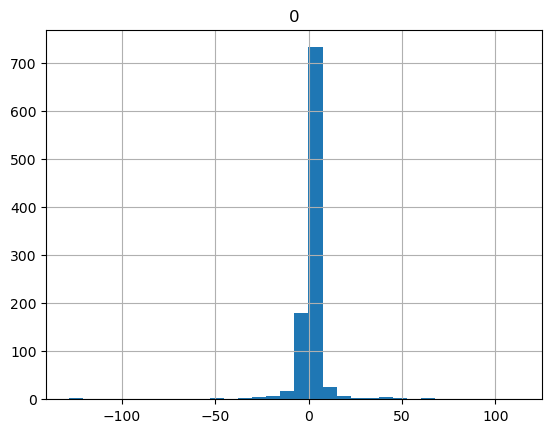

In [8]:
from matplotlib import pyplot as plt

B = pd.DataFrame([draw_b(100,lambda N: linear_dgp(N,1,0,.01,1,1))[1] for i in range(1000)])
B.hist(bins=int(np.ceil(np.sqrt(B.shape[0]))))

### Evaluation



Consider the $p-p$ plot of the empirical distribution of our estimates $b$ against the normal distribution:



<Axes: title={'center': 'p-p Plot'}, xlabel='Theoretical Distribution', ylabel='Empirical Distribution'>

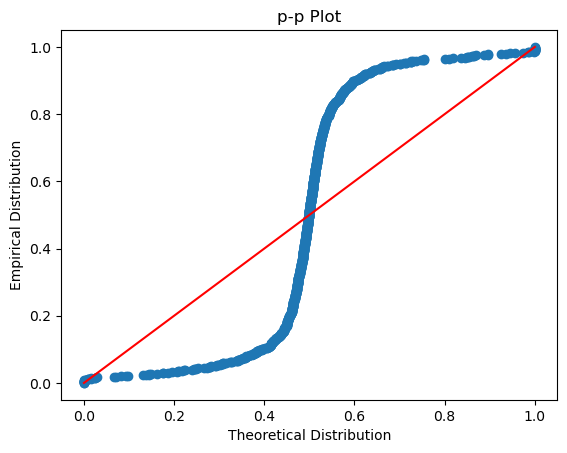

In [9]:
def ppplot(data,dist):
    data = np.array(data)

    # Theoretical CDF, evaluated at points of data
    P = [dist.cdf(x) for x in data.tolist()]

    # Empirical CDF, evaluated at points of data
    Phat = [(data<x).mean() for x in data.tolist()]

    fig, ax = plt.subplots()
    
    ax.scatter(P,Phat)
    ax.plot([0,1],[0,1],color='r') # Plot 45
    ax.set_xlabel('Theoretical Distribution')
    ax.set_ylabel('Empirical Distribution')
    ax.set_title('p-p Plot')

    return ax

ppplot(B,iid.norm(loc=B.mean(),scale=B.std()))